<center><h1>Chen_Shufen_HW8</h1></center>

Name: Shufen Chen
<br>
Github Username: shufench-usc
<br>
USC ID: 9180940635

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay, silhouette_score
from sklearn.preprocessing import StandardScaler, Normalizer    
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")



### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [12]:
# get the Breast Cancer Wisconsin (Diagnostic) Dataset
wdbc = pd.read_csv("../data/wdbc.data", header=None)

# get the feature names and apply them to the DataFrame
col_name = ["ID", "Diagnosis"]
feat = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
feats = list(f"{x}{y}" for y in range(1, 4) for x in feat)
col_name.extend(feats)
wdbc.columns = col_name

# convert the Diagnosis from B/M to 0/1
wdbc["Diagnosis"] = wdbc["Diagnosis"].map({"B": 0, "M": 1})

# drop the ID column
wdbc = wdbc.drop(columns=["ID"])

# check the data set
display(wdbc)

,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

In [13]:
def data_split(df):
    """
    This function splits the dataset into training set and test set randomly.
    The 20% of both the positive and negative classes as the test set.

    Parameters:
    df(DataFrame): the input dataframe

    Returns:
    X_train(DataFrame): the training features
    X_test(DataFrame): the test features
    y_train(Series): the training labels
    y_test(Series): the test labels
    """

    # get the features and labels
    X = df.drop(columns=["Diagnosis"])
    y = df["Diagnosis"]
    
    # split the dataset into training set and test set randomly
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(0, 100), stratify=y)

    return X_train, X_test, y_train, y_test
    

In [14]:
def linearsvc_supervised(X_train, X_test, y_train, y_test, c_range):
    """
    This function perform a grid search to find the best parameter for l1-penalized SVM, and reports the model performance.

    parameters:
    X_train: the training features
    X_test: the test features
    y_train: the training labels
    y_test: the test labels
    c_range: range of C values to try

    returns:
    re_df: a dataframe containing the best parameter, model and results
    """

    # 5-fold cross-validation for graid search
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # model settings: l1-penalized SVM
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svm", (LinearSVC(penalty="l1", dual=False, max_iter=100000))),
        ]
    )
    
    # grid search for parameters
    grid_search = GridSearchCV(
        estimator=pipe, param_grid={"svm__C": c_range}, cv=cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # best parameter and best model
    best_c = grid_search.best_params_["svm__C"]
    best_model = grid_search.best_estimator_

    # calculate the training metrics and test metrics
    y_tr_pred = best_model.predict(X_train)
    y_te_pred = best_model.predict(X_test)

    # training and test accuracy
    acc_tr = accuracy_score(y_train, y_tr_pred)
    acc_te = accuracy_score(y_test, y_te_pred)

    # precision
    pre_tr = precision_score(y_train, y_tr_pred)
    pre_te = precision_score(y_test, y_te_pred)

    # recall
    rec_tr = recall_score(y_train, y_tr_pred)
    rec_te = recall_score(y_test, y_te_pred)

    # f1 score
    f1_tr = f1_score(y_train, y_tr_pred)
    f1_te = f1_score(y_test, y_te_pred)

    # auc score
    auc_tr = roc_auc_score(y_train, best_model.decision_function(X_train))
    auc_te = roc_auc_score(y_test, best_model.decision_function(X_test))

    # confusion matrix
    cm_tr = confusion_matrix(y_train, y_tr_pred)
    cm_te = confusion_matrix(y_test, y_te_pred)

    # save the results into a dataframe
    re_df = pd.DataFrame({"C": [best_c], "model": [best_model], "accuracy_train": [acc_tr], "accuracy_test": [acc_te], "precision_train": [pre_tr], "precision_test": [pre_te], "recall_train": [rec_tr], "recall_test": [rec_te], "f1_train": [f1_tr], "f1_test": [f1_te], "auc_train": [auc_tr], "auc_test": [auc_te], "confusion_matrix_train": [cm_tr], "confusion_matrix_test": [cm_te]})

    return re_df

Confusion Matrix (Training Set):
[[285   0]
 [  2 168]]


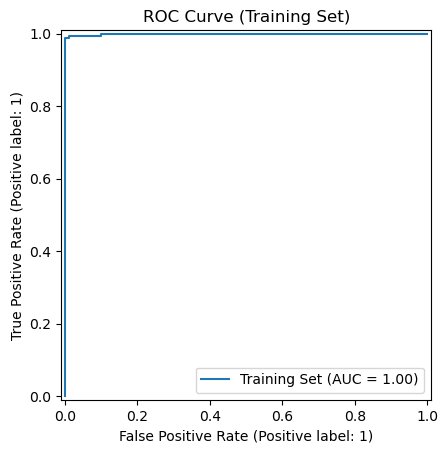

Confusion Matrix (Testing Set):
[[70  2]
 [ 3 39]]


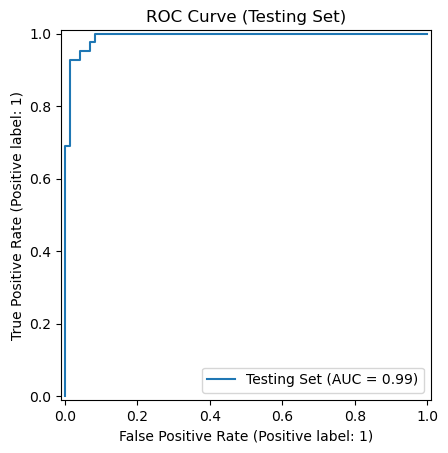

,C,model,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test,confusion_matrix_train,confusion_matrix_test
0,0.042813,"(StandardScaler(), LinearSVC(C=0.0428133239871...",0.986813,0.973684,0.993976,1.000000,0.970588,0.928571,0.982143,0.962963,0.995686,0.999669,"[[284, 1], [5, 165]]","[[72, 0], [3, 39]]"
1,3.359818,"(StandardScaler(), LinearSVC(C=3.3598182862837...",0.993407,0.938596,1.000000,0.926829,0.982353,0.904762,0.991098,0.915663,0.999794,0.967923,"[[285, 0], [3, 167]]","[[69, 3], [4, 38]]"
2,0.042813,"(StandardScaler(), LinearSVC(C=0.0428133239871...",0.978022,0.973684,0.976190,0.975610,0.964706,0.952381,0.970414,0.963855,0.997276,0.985119,"[[281, 4], [6, 164]]","[[71, 1], [2, 40]]"
3,0.183298,"(StandardScaler(), LinearSVC(C=0.1832980710832...",0.986813,0.964912,0.988095,0.952381,0.976471,0.952381,0.982249,0.952381,0.998060,0.994378,"[[283, 2], [4, 166]]","[[70, 2], [2, 40]]"
4,0.379269,"(StandardScaler(), LinearSVC(C=0.3792690190732...",0.986813,0.973684,0.982353,0.953488,0.982353,0.976190,0.982353,0.964706,0.999340,0.989749,"[[282, 3], [3, 167]]","[[70, 2], [1, 41]]"
5,0.088587,"(StandardScaler(), LinearSVC(C=0.0885866790410...",0.982418,0.973684,0.987952,1.000000,0.964706,0.928571,0.976190,0.962963,0.995996,0.991071,"[[283, 2], [6, 164]]","[[72, 0], [3, 39]]"
6,3.359818,"(StandardScaler(), LinearSVC(C=3.3598182862837...",0.993407,0.938596,1.000000,0.926829,0.982353,0.904762,0.991098,0.915663,0.999794,0.967923,"[[285, 0], [3, 167]]","[[69, 3], [4, 38]]"
7,0.183298,"(StandardScaler(), LinearSVC(C=0.1832980710832...",0.986813,0.991228,0.993976,1.000000,0.970588,0.976190,0.982143,0.987952,0.996533,0.999339,"[[284, 1], [5, 165]]","[[72, 0], [1, 41]]"
8,0.042813,"(StandardScaler(), LinearSVC(C=0.0428133239871...",0.989011,0.956140,0.994012,0.974359,0.976471,0.904762,0.985163,0.938272,0.995810,0.988426,"[[284, 1], [4, 166]]","[[71, 1], [4, 38]]"
9,0.042813,"(StandardScaler(), LinearSVC(C=0.0428133239871...",0.978022,0.973684,0.987805,0.953488,0.952941,0.976190,0.970060,0.964706,0.995624,0.997685,"[[283, 2], [8, 162]]","[[70, 2], [1, 41]]"


In [15]:
# dateframe to store the results
svm_results = pd.DataFrame()

# Monte-Carlo simulation (M=30)
for i in range(30):
    X_train, X_test, y_train, y_test = data_split(wdbc)
    svm_res = linearsvc_supervised(X_train, X_test, y_train, y_test, c_range=np.logspace(-2, 4, 20))

    # plot the roc and report the confusion matrix for one run (i=15)
    if i == 15:
        # get the best model
        model = svm_res["model"].iloc[0]

        # report training confusion matrix
        print(f"Confusion Matrix (Training Set):\n{svm_res['confusion_matrix_train'].iloc[0]}")

        # plot ROC curve for training set
        RocCurveDisplay.from_estimator(model, X_train, y_train, name='Training Set')
        plt.title('ROC Curve (Training Set)')
        plt.show()

        # report testing confusion matrix
        print(f"Confusion Matrix (Testing Set):\n{svm_res['confusion_matrix_test'].iloc[0]}")

        # plot ROC curve for testing set
        RocCurveDisplay.from_estimator(model, X_test, y_test, name='Testing Set')
        plt.title('ROC Curve (Testing Set)')
        plt.show()

    # append the results to the dataframe
    svm_results = pd.concat([svm_results, svm_res], axis=0, ignore_index=True)
    
display(svm_results)

In [16]:
# calculate the average results
avg_results = svm_results.iloc[:,2:12].mean(axis=0)
new_name = ["accuracy", "precision", "recall", "f1", "auc"]

avg_df = pd.DataFrame({"train": {m: avg_results[f"{m}_train"] for m in new_name}, "test":  {m: avg_results[f"{m}_test"]  for m in new_name}}).T 

print("The average scores of the 30 runs:")
print(avg_df)

The average scores of the 30 runs:
       accuracy  precision    recall        f1       auc
train  0.986667   0.991425  0.972745  0.981975  0.997393
test   0.970760   0.971124  0.949206  0.959831  0.993000


#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [17]:
def linearsvc_semi_supervised(X_train, X_test, y_train, y_test, X_unlabeled, c_range):
    """
    This function performs a semi-supervised svm.

    parameters:
    X_train: the labeled training features
    X_test: the labeled test features
    y_train: the labeled training labels
    y_test: the labeled test labels
    unlabeled_df: the unlabeled data to use for semi-supervised learning
    c_range: range of C values to try

    returns:
    re_df: a dataframe containing the best parameter, model and results
    """

    # 5-fold cross-validation for graid search
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # model settings: l1-penalized SVM
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svm", (LinearSVC(penalty="l1", dual=False, max_iter=100000))),
        ]
    )
    
    # grid search for parameters
    grid_search = GridSearchCV(
        estimator=pipe, param_grid={"svm__C": c_range}, cv=cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # best parameter and best model
    best_c = grid_search.best_params_["svm__C"]
    best_model = grid_search.best_estimator_

    # fine the unlabeled data points which are farthest to the decision boundary and label them
    while len(X_unlabeled) > 0:
        # fine the unlabeled data points which are farthest to the decision boundary
        distance = best_model.decision_function(X_unlabeled)
        farthest_dp = np.argmax(np.abs(distance))

        # label the farthest data point
        x_dp = X_unlabeled.iloc[[farthest_dp]]
        y_dp_pred = best_model.predict(x_dp)

        # add the labeled data point to the training set and remove it from the unlabeled set
        X_train = pd.concat([X_train, x_dp], axis=0)
        y_train = pd.concat([y_train, pd.Series(y_dp_pred, index=x_dp.index)], axis=0)
        X_unlabeled = X_unlabeled.drop(index=x_dp.index)

        # retrain the model with the updated training set
        best_model.fit(X_train, y_train)


    # calculate the training metrics and test metrics
    y_tr_pred = best_model.predict(X_train)
    y_te_pred = best_model.predict(X_test)

    # training and test accuracy
    acc_tr = accuracy_score(y_train, y_tr_pred)
    acc_te = accuracy_score(y_test, y_te_pred)

    # precision
    pre_tr = precision_score(y_train, y_tr_pred)
    pre_te = precision_score(y_test, y_te_pred)

    # recall
    rec_tr = recall_score(y_train, y_tr_pred)
    rec_te = recall_score(y_test, y_te_pred)

    # f1 score
    f1_tr = f1_score(y_train, y_tr_pred)
    f1_te = f1_score(y_test, y_te_pred)

    # auc score
    auc_tr = roc_auc_score(y_train, best_model.decision_function(X_train))
    auc_te = roc_auc_score(y_test, best_model.decision_function(X_test))

    # confusion matrix
    cm_tr = confusion_matrix(y_train, y_tr_pred)
    cm_te = confusion_matrix(y_test, y_te_pred)

    # save the results into a dataframe
    re_df = pd.DataFrame({"C": [best_c], "model": [best_model], "accuracy_train": [acc_tr], "accuracy_test": [acc_te], "precision_train": [pre_tr], "precision_test": [pre_te], "recall_train": [rec_tr], "recall_test": [rec_te], "f1_train": [f1_tr], "f1_test": [f1_te], "auc_train": [auc_tr], "auc_test": [auc_te], "confusion_matrix_train": [cm_tr], "confusion_matrix_test": [cm_te]})

    return re_df

##### (B)

Confusion Matrix (Training Set):
[[290   0]
 [  0 165]]


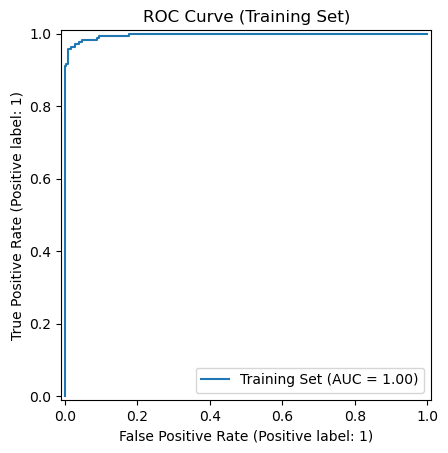

Confusion Matrix (Testing Set):
[[70  2]
 [ 3 39]]


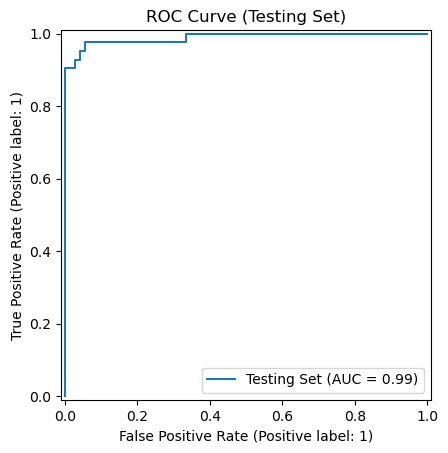

,C,model,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test,confusion_matrix_train,confusion_matrix_test
0,0.020691,"(StandardScaler(), LinearSVC(C=0.0206913808111...",0.980220,0.973684,0.993590,0.975610,0.950920,0.952381,0.971787,0.963855,0.994243,0.996693,"[[291, 1], [8, 155]]","[[71, 1], [2, 40]]"
1,0.784760,"(StandardScaler(), LinearSVC(C=0.7847599703514...",0.997802,0.991228,1.000000,0.976744,0.994118,1.000000,0.997050,0.988235,1.000000,1.000000,"[[285, 0], [1, 169]]","[[71, 1], [0, 42]]"
2,61.584821,"(StandardScaler(), LinearSVC(C=61.584821106602...",1.000000,0.973684,1.000000,0.975610,1.000000,0.952381,1.000000,0.963855,1.000000,0.974206,"[[288, 0], [0, 167]]","[[71, 1], [2, 40]]"
3,0.183298,"(StandardScaler(), LinearSVC(C=0.1832980710832...",0.995604,0.921053,1.000000,0.945946,0.988095,0.833333,0.994012,0.886076,0.999647,0.985780,"[[287, 0], [2, 166]]","[[70, 2], [7, 35]]"
4,0.183298,"(StandardScaler(), LinearSVC(C=0.1832980710832...",0.997802,0.938596,1.000000,0.972973,0.994186,0.857143,0.997085,0.911392,0.999897,0.993056,"[[283, 0], [1, 171]]","[[71, 1], [6, 36]]"
5,0.379269,"(StandardScaler(), LinearSVC(C=0.3792690190732...",0.993407,0.973684,0.994186,0.953488,0.988439,0.976190,0.991304,0.964706,0.999324,0.994378,"[[281, 1], [2, 171]]","[[70, 2], [1, 41]]"
6,0.088587,"(StandardScaler(), LinearSVC(C=0.0885866790410...",0.991209,0.973684,0.993827,0.975610,0.981707,0.952381,0.987730,0.963855,0.995935,0.996362,"[[290, 1], [3, 161]]","[[71, 1], [2, 40]]"
7,0.042813,"(StandardScaler(), LinearSVC(C=0.0428133239871...",0.991209,0.973684,1.000000,1.000000,0.975155,0.928571,0.987421,0.962963,0.999556,0.998016,"[[294, 0], [4, 157]]","[[72, 0], [3, 39]]"
8,0.042813,"(StandardScaler(), LinearSVC(C=0.0428133239871...",0.993407,0.964912,1.000000,1.000000,0.981132,0.904762,0.990476,0.950000,0.998938,0.981812,"[[296, 0], [3, 156]]","[[72, 0], [4, 38]]"
9,0.183298,"(StandardScaler(), LinearSVC(C=0.1832980710832...",0.995604,0.982456,1.000000,0.954545,0.988235,1.000000,0.994083,0.976744,0.999917,0.999669,"[[285, 0], [2, 168]]","[[70, 2], [0, 42]]"


In [18]:
# dateframe to store the results
semi_results = pd.DataFrame()

# Monte-Carlo simulation (M=30)
for i in range(30):
    X_train, X_test, y_train, y_test = data_split(wdbc)
    X_train_labeled,  X_unlabeled, y_train_labeled, y_true_label = train_test_split(X_train, y_train, test_size=0.5, random_state=i, stratify=y_train)
    
    semi_res = linearsvc_semi_supervised(X_train_labeled, X_test, y_train_labeled, y_test, X_unlabeled, c_range=np.logspace(-2, 4, 20))

    # plot the roc and report the confusion matrix for one run (i=15)
    if i == 15:
        # get the best model
        model = semi_res["model"].iloc[0]

        # report training confusion matrix
        print(f"Confusion Matrix (Training Set):\n{semi_res['confusion_matrix_train'].iloc[0]}")

        # plot ROC curve for training set
        RocCurveDisplay.from_estimator(model, X_train, y_train, name='Training Set')
        plt.title('ROC Curve (Training Set)')
        plt.show()

        # report testing confusion matrix
        print(f"Confusion Matrix (Testing Set):\n{semi_res['confusion_matrix_test'].iloc[0]}")

        # plot ROC curve for testing set
        RocCurveDisplay.from_estimator(model, X_test, y_test, name='Testing Set')
        plt.title('ROC Curve (Testing Set)')
        plt.show()

    # append the results to the dataframe
    semi_results = pd.concat([semi_results, semi_res], axis=0, ignore_index=True)
    
display(semi_results)

In [19]:
# calculate the average results
avg_results = semi_results.iloc[:,2:12].mean(axis=0)
avg_df = pd.DataFrame({"train": {m: avg_results[f"{m}_train"] for m in new_name}, "test":  {m: avg_results[f"{m}_test"]  for m in new_name}}).T 

print("The average scores of the 30 runs:")
print(avg_df)

The average scores of the 30 runs:
       accuracy  precision    recall        f1       auc
train  0.994799   0.997773  0.987932  0.992806  0.999109
test   0.962281   0.964413  0.933333  0.947785  0.991038


#### (iii) Unsupervised Learning

##### (A)

In [20]:
def k_means_clustering(X_train, y_train, X_test, y_test):
    """
    This function performs k-means clustering on the dataset
    
    Parameters:
    X_train(DataFrame): the training features
    y_train(Series): the training labels
    X_test(DataFrame): the test features
    y_test(Series): the test labels

    Returns:
    re_df: a dataframe containing the model and results
    """

    # run the k_means algorithm
    k_means = KMeans(n_clusters=2, init = "k-means++", n_init=20, random_state=random.randint(0, 100))
    k_means.fit(X_train)

    # compute the centers
    centers = k_means.cluster_centers_

    # compute the closest 30 points to the center in each cluster
    closest_dp = []
    for center in centers:
        distances = cdist(X_train, [center], metric="euclidean") 
        distances = distances.ravel()
        closest_idx = np.argsort(distances)[:30]
        closest_dp.append(closest_idx)

    # majority voting to assign labels to each cluster
    sum_c0 = y_train.iloc[closest_dp[0]].sum()
    sum_c1 = y_train.iloc[closest_dp[1]].sum()

    if sum_c0 > sum_c1:
        c0_label, c1_label = 1, 0
    else:
        c0_label, c1_label = 0, 1

    # predict the label of the training set
    labels = k_means.labels_
    y_tr_pred = np.where(labels == 0, c0_label, c1_label)
    
    # predict the label of the test set
    cluster_id_te = k_means.predict(X_test)
    y_te_pred = np.where(cluster_id_te == 0, c0_label, c1_label)

    # training and test accuracy
    acc_tr = accuracy_score(y_train, y_tr_pred)
    acc_te = accuracy_score(y_test, y_te_pred)

    # precision
    pre_tr = precision_score(y_train, y_tr_pred)
    pre_te = precision_score(y_test, y_te_pred)

    # recall
    rec_tr = recall_score(y_train, y_tr_pred)
    rec_te = recall_score(y_test, y_te_pred)

    # f1 score
    f1_tr = f1_score(y_train, y_tr_pred)
    f1_te = f1_score(y_test, y_te_pred)

    # auc score
    auc_tr = roc_auc_score(y_train, y_tr_pred)
    auc_te = roc_auc_score(y_test, y_te_pred)

    # confusion matrix
    cm_tr = confusion_matrix(y_train, y_tr_pred)
    cm_te = confusion_matrix(y_test, y_te_pred)

    # save the results into a dataframe
    re_df = pd.DataFrame({ "model": [k_means], "accuracy_train": [acc_tr], "accuracy_test": [acc_te], "precision_train": [pre_tr], "precision_test": [pre_te], "recall_train": [rec_tr], "recall_test": [rec_te], "f1_train": [f1_tr], "f1_test": [f1_te], "auc_train": [auc_tr], "auc_test": [auc_te], "confusion_matrix_train": [cm_tr], "confusion_matrix_test": [cm_te], "y_tr_pred": [y_tr_pred], "y_te_pred": [y_te_pred]})

    return re_df

##### (B)

Confusion Matrix (Training Set):
[[284   1]
 [ 65 105]]


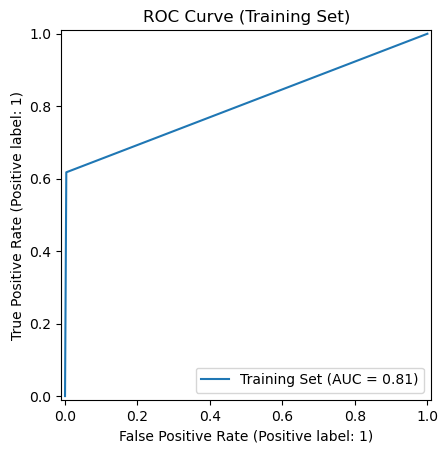

Confusion Matrix (Testing Set):
[[72  0]
 [15 27]]


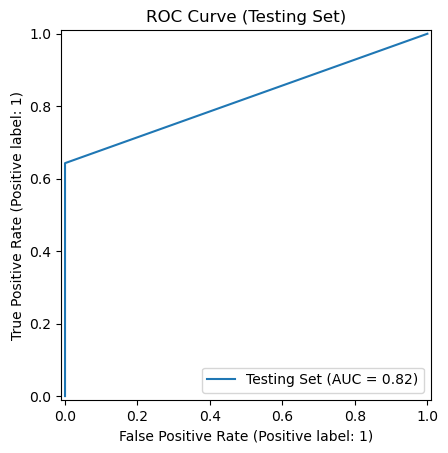

,model,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test,confusion_matrix_train,confusion_matrix_test,y_tr_pred,y_te_pred
0,"KMeans(n_clusters=2, n_init=20, random_state=35)",0.846154,0.877193,1.000000,0.966667,0.588235,0.690476,0.740741,0.805556,0.794118,0.838294,"[[285, 0], [70, 100]]","[[71, 1], [13, 29]]","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
1,"KMeans(n_clusters=2, n_init=20, random_state=66)",0.857143,0.833333,1.000000,0.960000,0.617647,0.571429,0.763636,0.716418,0.808824,0.778770,"[[285, 0], [65, 105]]","[[71, 1], [18, 24]]","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
2,"KMeans(n_clusters=2, n_init=20, random_state=94)",0.859341,0.833333,1.000000,0.960000,0.623529,0.571429,0.768116,0.716418,0.811765,0.778770,"[[285, 0], [64, 106]]","[[71, 1], [18, 24]]","[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,"KMeans(n_clusters=2, n_init=20, random_state=65)",0.854945,0.850877,1.000000,0.962963,0.611765,0.619048,0.759124,0.753623,0.805882,0.802579,"[[285, 0], [66, 104]]","[[71, 1], [16, 26]]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,"KMeans(n_clusters=2, n_init=20, random_state=14)",0.839560,0.912281,0.989899,1.000000,0.576471,0.761905,0.728625,0.864865,0.786481,0.880952,"[[284, 1], [72, 98]]","[[72, 0], [10, 32]]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ..."
5,"KMeans(n_clusters=2, n_init=20, random_state=78)",0.859341,0.833333,0.990741,1.000000,0.629412,0.547619,0.769784,0.707692,0.812951,0.773810,"[[284, 1], [63, 107]]","[[72, 0], [19, 23]]","[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
6,"KMeans(n_clusters=2, n_init=20, random_state=47)",0.839560,0.842105,0.989899,1.000000,0.576471,0.571429,0.728625,0.727273,0.786481,0.785714,"[[284, 1], [72, 98]]","[[72, 0], [18, 24]]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
7,"KMeans(n_clusters=2, n_init=20, random_state=26)",0.857143,0.859649,0.990654,1.000000,0.623529,0.619048,0.765343,0.764706,0.810010,0.809524,"[[284, 1], [64, 106]]","[[72, 0], [16, 26]]","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
8,"KMeans(n_clusters=2, n_init=20, random_state=97)",0.850549,0.868421,0.990385,1.000000,0.605882,0.642857,0.751825,0.782609,0.801187,0.821429,"[[284, 1], [67, 103]]","[[72, 0], [15, 27]]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
9,"KMeans(n_clusters=2, n_init=20, random_state=93)",0.857143,0.842105,0.990654,1.000000,0.623529,0.571429,0.765343,0.727273,0.810010,0.785714,"[[284, 1], [64, 106]]","[[72, 0], [18, 24]]","[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."


In [21]:
kmeans_results = pd.DataFrame()

for i in range(50):
    X_train, X_test, y_train, y_test = data_split(wdbc)

    kmean_res = k_means_clustering(X_train, y_train, X_test, y_test)

    # plot the roc and report the confusion matrix for one run (i=15)
    if i == 15:
        # get the predited labels for training and testing sets
        y_tr_pred = kmean_res["y_tr_pred"].iloc[0]
        y_te_pred = kmean_res["y_te_pred"].iloc[0]

        # report training confusion matrix
        print(f"Confusion Matrix (Training Set):\n{kmean_res['confusion_matrix_train'].iloc[0]}")

        # plot ROC curve for training set
        RocCurveDisplay.from_predictions(y_train, y_tr_pred, name='Training Set')
        plt.title('ROC Curve (Training Set)')
        plt.show()

        # report testing confusion matrix
        print(f"Confusion Matrix (Testing Set):\n{ kmean_res['confusion_matrix_test'].iloc[0]}")

        # plot ROC curve for testing set
        RocCurveDisplay.from_predictions(y_test, y_te_pred, name='Testing Set')
        plt.title('ROC Curve (Testing Set)')
        plt.show()

    # append the results to the dataframe
    kmeans_results = pd.concat([kmeans_results,  kmean_res], axis=0, ignore_index=True)
    
display(kmeans_results)

In [22]:
# calculate the average results
avg_results = kmeans_results.iloc[:,1:11].mean(axis=0)
avg_df = pd.DataFrame({"train": {m: avg_results[f"{m}_train"] for m in new_name}, "test":  {m: avg_results[f"{m}_test"]  for m in new_name}}).T 

print("The average scores of the 30 runs:")
print(avg_df)

The average scores of the 30 runs:
       accuracy  precision    recall        f1       auc
train  0.850901    0.99289  0.605294  0.751755  0.801349
test   0.853158    0.98997  0.607619  0.750377  0.802004


#### (iv) Spectral Clustering

In [23]:
def Spectral_clustering(X_train, y_train, X_test, y_test):
    """
    This function performs spectral clustering on the dataset.add
    
    Parameters:
    X_train(DataFrame): the training features
    k(int): number of clusters
    
    Returns:
    """
    # standardize the dataset
    normalizer = Normalizer()
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

    # run the spectral clustering algorithm
    spectral_means = SpectralClustering(n_clusters=2, affinity="rbf", gamma = 1, random_state=random.randint(0, 100))
    labels = spectral_means.fit_predict(X_train)

    # assign the labels of the clusters
    if np.dot(y_train, labels) < np.dot(y_train, 1 - labels):
        y_train_spectral = 1 - labels
    else:
        y_train_spectral = labels

    # knn classifier on the spectral clustering labels
    knn = KNeighborsClassifier(n_neighbors=30)
    knn.fit(X_train, y_train_spectral)

    y_tr_pred = knn.predict(X_train)
    y_te_pred = knn.predict(X_test)

    # training and test accuracy
    acc_tr = accuracy_score(y_train, y_tr_pred)
    acc_te = accuracy_score(y_test, y_te_pred)

    # precision
    pre_tr = precision_score(y_train, y_tr_pred)
    pre_te = precision_score(y_test, y_te_pred)

    # recall
    rec_tr = recall_score(y_train, y_tr_pred)
    rec_te = recall_score(y_test, y_te_pred)

    # f1 score
    f1_tr = f1_score(y_train, y_tr_pred)
    f1_te = f1_score(y_test, y_te_pred)

    # auc score
    auc_tr = roc_auc_score(y_train, y_tr_pred)
    auc_te = roc_auc_score(y_test, y_te_pred)

    # confusion matrix
    cm_tr = confusion_matrix(y_train, y_tr_pred)
    cm_te = confusion_matrix(y_test, y_te_pred)

    # save the results into a dataframe
    re_df = pd.DataFrame({ "model": [spectral_means], "accuracy_train": [acc_tr], "accuracy_test": [acc_te], "precision_train": [pre_tr], "precision_test": [pre_te], "recall_train": [rec_tr], "recall_test": [rec_te], "f1_train": [f1_tr], "f1_test": [f1_te], "auc_train": [auc_tr], "auc_test": [auc_te], "confusion_matrix_train": [cm_tr], "confusion_matrix_test": [cm_te], "y_tr_pred": [y_tr_pred], "y_te_pred": [y_te_pred]})

    return re_df

Confusion Matrix (Training Set):
[[281   4]
 [ 49 121]]


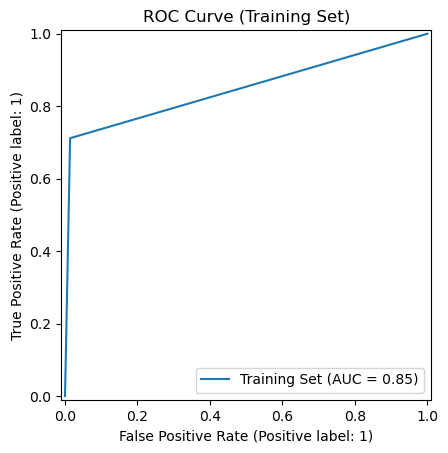

Confusion Matrix (Testing Set):
[[71  1]
 [14 28]]


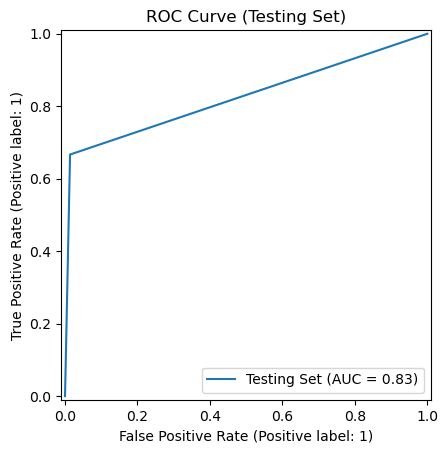

,model,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test,confusion_matrix_train,confusion_matrix_test,y_tr_pred,y_te_pred
0,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.881319,0.894737,0.967742,0.968750,0.705882,0.738095,0.816327,0.837838,0.845924,0.862103,"[[281, 4], [50, 120]]","[[71, 1], [11, 31]]","[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.901099,0.850877,0.969925,0.931034,0.758824,0.642857,0.851485,0.760563,0.872394,0.807540,"[[281, 4], [41, 129]]","[[70, 2], [15, 27]]","[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, ..."
2,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.876923,0.894737,0.967213,0.968750,0.694118,0.738095,0.808219,0.837838,0.840041,0.862103,"[[281, 4], [52, 118]]","[[71, 1], [11, 31]]","[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, ..."
3,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.885714,0.885965,0.968254,0.967742,0.717647,0.714286,0.824324,0.821918,0.851806,0.850198,"[[281, 4], [48, 122]]","[[71, 1], [12, 30]]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ..."
4,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.874725,0.885965,0.959350,1.000000,0.694118,0.690476,0.805461,0.816901,0.838287,0.845238,"[[280, 5], [52, 118]]","[[72, 0], [13, 29]]","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, ..."
5,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.883516,0.921053,0.946565,1.000000,0.729412,0.785714,0.823920,0.880000,0.852425,0.892857,"[[278, 7], [46, 124]]","[[72, 0], [9, 33]]","[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ..."
6,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.890110,0.850877,0.968750,0.962963,0.729412,0.619048,0.832215,0.753623,0.857688,0.802579,"[[281, 4], [46, 124]]","[[71, 1], [16, 26]]","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
7,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.881319,0.894737,0.967742,0.968750,0.705882,0.738095,0.816327,0.837838,0.845924,0.862103,"[[281, 4], [50, 120]]","[[71, 1], [11, 31]]","[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..."
8,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.890110,0.868421,0.976190,0.935484,0.723529,0.690476,0.831081,0.794521,0.856502,0.831349,"[[282, 3], [47, 123]]","[[70, 2], [13, 29]]","[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, ...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, ..."
9,"SpectralClustering(gamma=1, n_clusters=2, rand...",0.887912,0.877193,0.947368,1.000000,0.741176,0.666667,0.831683,0.800000,0.858308,0.833333,"[[278, 7], [44, 126]]","[[72, 0], [14, 28]]","[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."


In [24]:
sc_results = pd.DataFrame()

for i in range(50):
    X_train, X_test, y_train, y_test = data_split(wdbc)

    sc_res = Spectral_clustering(X_train, y_train, X_test, y_test)

    # plot the roc and report the confusion matrix for one run (i=15)
    if i == 15:
        # get the predited labels for training and testing sets
        y_tr_pred = sc_res["y_tr_pred"].iloc[0]
        y_te_pred = sc_res["y_te_pred"].iloc[0]

        # report training confusion matrix
        print(f"Confusion Matrix (Training Set):\n{sc_res['confusion_matrix_train'].iloc[0]}")

        # plot ROC curve for training set
        RocCurveDisplay.from_predictions(y_train, y_tr_pred, name='Training Set')
        plt.title('ROC Curve (Training Set)')
        plt.show()

        # report testing confusion matrix
        print(f"Confusion Matrix (Testing Set):\n{ sc_res['confusion_matrix_test'].iloc[0]}")

        # plot ROC curve for testing set
        RocCurveDisplay.from_predictions(y_test, y_te_pred, name='Testing Set')
        plt.title('ROC Curve (Testing Set)')
        plt.show()

    # append the results to the dataframe
    sc_results = pd.concat([sc_results,  sc_res], axis=0, ignore_index=True)
    
display(sc_results)

In [25]:
# calculate the average results
avg_results = sc_results.iloc[:,1:11].mean(axis=0)
avg_df = pd.DataFrame({"train": {m: avg_results[f"{m}_train"] for m in new_name}, "test":  {m: avg_results[f"{m}_test"]  for m in new_name}}).T 

print("The average scores of the 30 runs:")
print(avg_df)

The average scores of the 30 runs:
       accuracy  precision    recall        f1       auc
train  0.881670   0.966021  0.708353  0.817078  0.846703
test   0.878596   0.966651  0.694762  0.807428  0.840298


#### (iv) Compare

Overall, supervised learning performs the best across all the metrics. Semi-supervised learning performs the worse than supervised learning. And the unsupervised learning performs the worst.

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [3]:
# get the banknote authentication dataset
bda = pd.read_csv("../data/data_banknote_authentication.txt", header=None)

# rename the columns
bda.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
display(bda)

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bda.drop('class', axis=1), bda['class'], test_size=472, random_state=42, stratify=bda['class'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


(900, 4) (472, 4) (900,) (472,)


### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [4]:
# list to store the results
total_results_passive = []

# parameters for grid search
c_range = np.logspace(-2, 4, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in range(50):
    # split the training set into two classes(0 and 1)
    X0 = X_train[y_train == 0]
    X1 = X_train[y_train == 1]

    y0 = y_train[y_train == 0]
    y1 = y_train[y_train == 1]

    # shuffle the two classes separately
    X0_sh, y0_sh = shuffle(X0, y0, random_state=i)
    X1_sh, y1_sh = shuffle(X1, y1, random_state=i)

    # reunion the two classes and shuffle again
    X_train_shuffled = pd.concat([X0_sh, X1_sh], axis=0).sample(frac=1, random_state=i).reset_index(drop=True)
    y_train_shuffled = pd.concat([y0_sh, y1_sh], axis=0).sample(frac=1, random_state=i).reset_index(drop=True)  

    # list to store the results for each batch  
    batch_results = []

    for j in range(10, 901, 10):
        # split the training set into training and pool sets
        X_train_pool = X_train_shuffled.iloc[:j]
        y_train_pool = y_train_shuffled.iloc[:j]

        # model settings: l1-penalized SVM
        model = LinearSVC(penalty="l1", dual=False)
        
        # grid search for parameters
        grid_search = GridSearchCV(
            estimator=model, param_grid={"C": c_range}, cv=cv, n_jobs=-1
        )
        grid_search.fit(X_train_pool, y_train_pool)

        # best parameter and best model
        best_model = grid_search.best_estimator_

        # calculate the test error
        y_te_pred = best_model.predict(X_test)
        acc_te = accuracy_score(y_test, y_te_pred)
        err_te = 1 - acc_te
        
        # save the results into a dataframe
        batch_results.append(err_te)

    total_results_passive.append(batch_results)

trp_df = pd.DataFrame(total_results_passive)
display(trp_df)


,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.154661,0.040254,0.061441,0.052966,0.036017,0.038136,0.036017,0.033898,0.023305,0.014831,...,0.006356,0.008475,0.008475,0.006356,0.008475,0.008475,0.008475,0.019068,0.008475,0.008475
1,0.040254,0.046610,0.038136,0.038136,0.038136,0.038136,0.038136,0.038136,0.038136,0.033898,...,0.012712,0.008475,0.012712,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475
2,0.040254,0.038136,0.027542,0.031780,0.008475,0.019068,0.021186,0.021186,0.010593,0.019068,...,0.008475,0.012712,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475,0.012712,0.008475
3,0.154661,0.154661,0.038136,0.048729,0.038136,0.025424,0.036017,0.038136,0.038136,0.036017,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.012712
4,0.154661,0.154661,0.154661,0.154661,0.033898,0.019068,0.036017,0.033898,0.036017,0.031780,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475
5,0.118644,0.095339,0.033898,0.019068,0.021186,0.031780,0.036017,0.033898,0.021186,0.019068,...,0.008475,0.008475,0.008475,0.012712,0.012712,0.012712,0.008475,0.008475,0.008475,0.008475
6,0.154661,0.154661,0.154661,0.038136,0.033898,0.036017,0.036017,0.036017,0.036017,0.036017,...,0.008475,0.019068,0.012712,0.010593,0.019068,0.012712,0.012712,0.012712,0.008475,0.012712
7,0.154661,0.052966,0.042373,0.036017,0.036017,0.025424,0.033898,0.033898,0.033898,0.025424,...,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475
8,0.038136,0.023305,0.029661,0.029661,0.027542,0.042373,0.036017,0.025424,0.023305,0.021186,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.012712
9,0.057203,0.036017,0.038136,0.038136,0.036017,0.038136,0.036017,0.036017,0.036017,0.036017,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475


#### (ii) Active

In [5]:
# list to store the results
total_results_active = []

# parameters for grid search
c_range = np.logspace(-2, 4, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in range(50):
    # split the training set into two classes(0 and 1)
    X0 = X_train[y_train == 0]
    X1 = X_train[y_train == 1]

    y0 = y_train[y_train == 0]
    y1 = y_train[y_train == 1]

    # Shuffle each class separately
    X0_sh, y0_sh = shuffle(X0, y0, random_state=i)
    X1_sh, y1_sh = shuffle(X1, y1, random_state=i)

    # reunion the two classes and shuffle again
    X_train_balanced = pd.concat([X0_sh, X1_sh], axis=0)
    y_train_balanced = pd.concat([y0_sh, y1_sh], axis=0)

    X_train_shuffled = X_train_balanced.sample(frac=1, random_state=i).reset_index(drop=True)
    y_train_shuffled = y_train_balanced.sample(frac=1, random_state=i).reset_index(drop=True)

    # convert to numpy arrays for indexing
    X_arr = X_train_shuffled.to_numpy()
    y_arr = y_train_shuffled.to_numpy()

    n_train = X_arr.shape[0]
    all_idx = np.arange(n_train)

    # selected 10 random data points as initial labeled pool
    rng = np.random.default_rng(seed=i)
    selected_idx = rng.choice(all_idx, size=10, replace=False)  
    y_pool = y_arr[selected_idx]
    
    while np.unique(y_pool).size < 2:
        selected_idx = rng.choice(all_idx, size=10, replace=False)
        y_pool = y_arr[selected_idx]

    remain_idx = np.setdiff1d(all_idx, selected_idx, assume_unique=True)    

    batch_results = []  

    for j in range(10, 901, 10):
        # Current labeled set
        X_pool = X_arr[selected_idx]
        y_pool = y_arr[selected_idx]

        # model settings: l1-penalized SVM
        model = LinearSVC(penalty="l1", dual=False)

        # grid search for parameters
        grid_search = GridSearchCV(
            estimator=model,
            param_grid={"C": c_range},
            cv=cv,
            n_jobs=-1
        )
        grid_search.fit(X_pool, y_pool)
        best_model = grid_search.best_estimator_

        # calculate the test error
        y_te_pred = best_model.predict(X_test)
        acc_te = accuracy_score(y_test, y_te_pred)
        err_te = 1.0 - acc_te  

        batch_results.append(err_te)

        # When j reaches 900, stop 
        if j == 900:
            break

        # process remaining points
        X_unl = X_arr[remain_idx]
        distances = np.abs(best_model.decision_function(X_unl))

        # 10 points closest to the boundary
        smallest_idx_in_remain = np.argsort(distances)[:10]
        new_idx = remain_idx[smallest_idx_in_remain]

        # update pools
        selected_idx = np.concatenate([selected_idx, new_idx])
        remain_idx = np.delete(remain_idx, smallest_idx_in_remain)

    total_results_active.append(batch_results)

tra_df = pd.DataFrame(total_results_active)
display(tra_df)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.038136,0.010593,0.027542,0.008475,0.008475,0.008475,0.008475,0.012712,0.012712,0.008475,...,0.008475,0.008475,0.008475,0.012712,0.012712,0.008475,0.008475,0.012712,0.008475,0.012712
1,0.065678,0.008475,0.014831,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.012712,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.012712,0.008475,0.008475
2,0.184322,0.082627,0.031780,0.023305,0.025424,0.019068,0.016949,0.008475,0.012712,0.012712,...,0.008475,0.008475,0.008475,0.012712,0.008475,0.012712,0.012712,0.008475,0.008475,0.008475
3,0.296610,0.112288,0.067797,0.019068,0.038136,0.021186,0.012712,0.008475,0.012712,0.008475,...,0.010593,0.008475,0.008475,0.008475,0.008475,0.010593,0.008475,0.008475,0.012712,0.008475
4,0.173729,0.036017,0.033898,0.025424,0.023305,0.021186,0.012712,0.008475,0.008475,0.012712,...,0.008475,0.008475,0.012712,0.010593,0.008475,0.008475,0.008475,0.008475,0.010593,0.008475
5,0.154661,0.122881,0.069915,0.050847,0.042373,0.033898,0.021186,0.021186,0.021186,0.010593,...,0.008475,0.012712,0.008475,0.008475,0.012712,0.012712,0.008475,0.012712,0.010593,0.010593
6,0.036017,0.031780,0.025424,0.025424,0.019068,0.019068,0.021186,0.016949,0.012712,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712
7,0.182203,0.036017,0.023305,0.012712,0.012712,0.008475,0.010593,0.008475,0.008475,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.012712,0.008475
8,0.150424,0.046610,0.040254,0.021186,0.012712,0.012712,0.008475,0.008475,0.008475,0.012712,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.012712,0.010593
9,0.167373,0.023305,0.021186,0.016949,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,...,0.008475,0.012712,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475


### (c) Average the 50 test errors

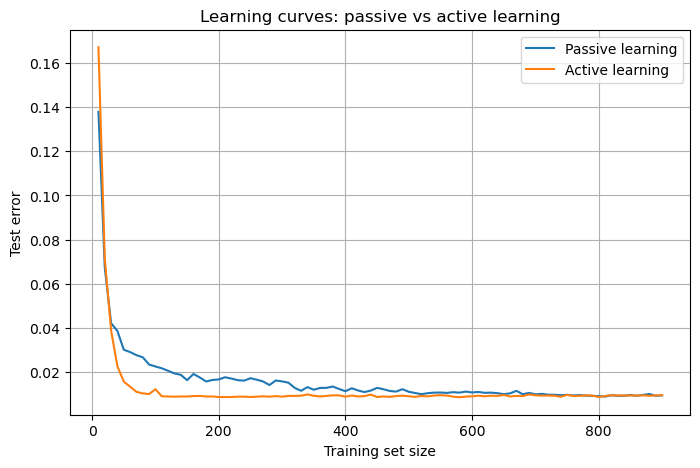

In [6]:
passive_mean = trp_df.mean(axis=0).to_numpy()   
active_mean  = tra_df.mean(axis=0).to_numpy()  

x = np.arange(10, 901, 10)

plt.figure(figsize=(8, 5))
plt.plot(x, passive_mean, label="Passive learning")
plt.plot(x, active_mean,  label="Active learning")
plt.xlabel("Training set size")
plt.ylabel("Test error")
plt.title("Learning curves: passive vs active learning")
plt.legend()
plt.grid(True)
plt.show()

Conclusion: 
When the size of the training pool is small(<600), the active learning method achieves lower test error than passive learning. As the training pool increases, the gap between the two methods becomes smaller. Finally, their performance becomes very similar.